In [11]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
%matplotlib inline

In [12]:
filepath = "C:\\Users\\hp\\Python_Project\\xylene-e-nose\\Data_100ppm\\"
Data = []
for file in os.listdir(filepath):
    data = pd.read_excel(filepath+file)
    Data.append(data)
gas=[]
for i in range(len(Data)):
    gas.append(os.listdir(filepath)[i][0:4])

In [13]:
gas

['100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ',
 '100 ']

In [14]:
def data_preprocessing(Data,Col):
    New_Data=[]
    for i in range(len(Data)):
        data = Data[i]
        new_data = data.iloc[3:]
        new_data = new_data[Col[i]]
        New_Data.append(new_data)
    return New_Data


def choose_points(data,mode,zone,num_of_points):
    time = data['Time']
    matrix_mx3 = data[data.columns[1:]].values
    if mode==1:
        index = np.sum(time<zone)
        return matrix_mx3[max(0,index-num_of_points):index]
    elif mode==2:
        index1 = np.sum(time<zone[0])
        index2 = np.sum(time<zone[1])
        return matrix_mx3[index1:index2]
    
#mode=1时，zone:[1200,1200,1200] / 1200；mode=2时，zone为长度为2的列表
def X_and_y(Data,mode,zone,num_of_points=0):
    if type(zone)!=list:
        zone = [zone]*len(Data)
    length = len(Data[0].columns)-1
    X = np.empty([0,length])
    y = np.empty(0)
    label = 0
    for data in Data:
        label = label+1
        m = choose_points(data,mode,zone[label-1],num_of_points).shape[0]
        X = np.append(X,choose_points(data,mode,zone[label-1],num_of_points),axis=0)
        y = np.append(y,label*np.ones(m))
    Combine = np.hstack((X,y.reshape(-1,1)))
    np.random.shuffle(Combine)
    X = Combine[:,:-1]
    y = Combine[:,-1]
    y = y.astype(np.int)
    return (X,y)

def show_result(X,y,rate,k,sigma):
    while True:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = rate)
        if np.all(np.unique(y_test)==np.unique(y_train)):
            break
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    y_pred = KNN(X_train,y_train,X_test,k,sigma)
    result = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(result)
    result1 = classification_report(y_test, y_pred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,y_pred)
    print("Accuracy:",result2)
    return result,result2

def many_times_test(X,y,times,rate=0.1,k=10,sigma=0.1):
    summe = 0
    summe2 = 0
    for i in range(times):
        result,result2=show_result(X,y,rate,k,sigma)
        summe = summe+result
        summe2 = summe2+result2
    print("The sum of all confusion matrices is:\n")
    print(summe)
    print('****************************************')
    print('Average Accuracy: ',summe2/times)
        
        
def find_k_nearst_neighbor(X_train,point,k,sigma):
    distances = np.sum((X_train-point)**2,axis=1)**0.5
    distances = 1/2*(distances-2*sigma+np.abs(distances-2*sigma))
    return np.argsort(distances)[:k]

def KNN(X_train,y_train,X_test,k,sigma):
    m = X_test.shape[0]
    y_pred = np.zeros(m)
    for i in range(m):
        neighbours = find_k_nearst_neighbor(X_train,X_test[i],k,sigma)
       # neighbours = neighbours.astype(np.int)
        counts = np.bincount(y_train[neighbours].astype(np.int))
        y_pred[i]=np.argmax(counts)
    return y_pred

def change_Data(Data,w):
    D=[]
    length = len(Data[0].columns)-1
    for data in Data:
        d = data.copy()
        for i in range(1,length+1):
            d['new'] = d.iloc[:,i].rolling(window=w).mean()
            d.iloc[:,i] = d['new']
        d = d.drop(columns='new')
        D.append(d.iloc[w-1:])
    return D 

def plot_kurve(Data,zone,num_of_points,Columns,sort=0,rolling=False,w = 5,mode=1):
    D = []
    length = len(Data[0].columns)-1
    if type(zone)!=list:
        zone = [zone]*len(Data)
    plt.figure(figsize=(15,6*len(Data)))
    for i in range(len(Data)):
        data = Data[i]
        time = data['Time'].values      
        if mode==1:
            time = time[time<zone[i]]
            time = time[-num_of_points:]
        elif mode==2:
            time = time[time<zone[-1]]
            time = time[time>zone[0]]
        d = pd.DataFrame(columns=data.columns)
        d['Time']=time[(w-1)*int(rolling):]
        if rolling:
            points = choose_points(data,mode,zone[i],num_of_points-w+1)
        else:
            points = choose_points(data,mode,zone[i],num_of_points)
        for column in range(length):
            d.iloc[:,column+1]=points[:,column]
        D.append(d)
        if sort!=0:
            for column in range(points.shape[1]):
                points[:,column] = points[:,column][np.argsort(points[:,column])] 
        plt.subplot(len(Data),1,i+1)
        for j in range(length):
            plt.plot(time[(w-1)*int(rolling):],points[:,j],'x',label = Columns[i][j+1]) 
        plt.legend()
        plt.title(gas[i])
    return D


In [15]:
#顺序是m o p
col1 = ['Time','c1','c2','c3','c4','c5','c6']
col2 = ['Time','c1','c2','c3','c4','c5','c6']
col3 = ['Time','c1','c2','c3','c4','c5','c6']
col4 = ['Time','c1','c2','c3','c4','c5','c6']
col5 = ['Time','c1','c2','c3','c4','c5','c6']
col6 = ['Time','c1','c2','c3','c4','c5','c6']
col7 = ['Time','c1','c2','c3','c4','c5','c6']
col8 = ['Time','c1','c2','c3','c4','c5','c6']
col9 = ['Time','c1','c2','c3','c4','c5','c6']
col10 = ['Time','c1','c2','c3','c4','c5','c6']
col11 = ['Time','c1','c2','c3','c4','c5','c6']
col12 = ['Time','c1','c2','c3','c4','c5','c6']
col13 = ['Time','c1','c2','c3','c4','c5','c6']
col14 = ['Time','c1','c2','c3','c4','c5','c6']
col15 = ['Time','c1','c2','c3','c4','c5','c6']
col16 = ['Time','c1','c2','c3','c4','c5','c6']
Col = [col1,col2,col3,col4,col5,col6,col7,col8,col9,col10,col11,col12,col13,col14,col15,col16]
Processed_Data = data_preprocessing(Data,Col)

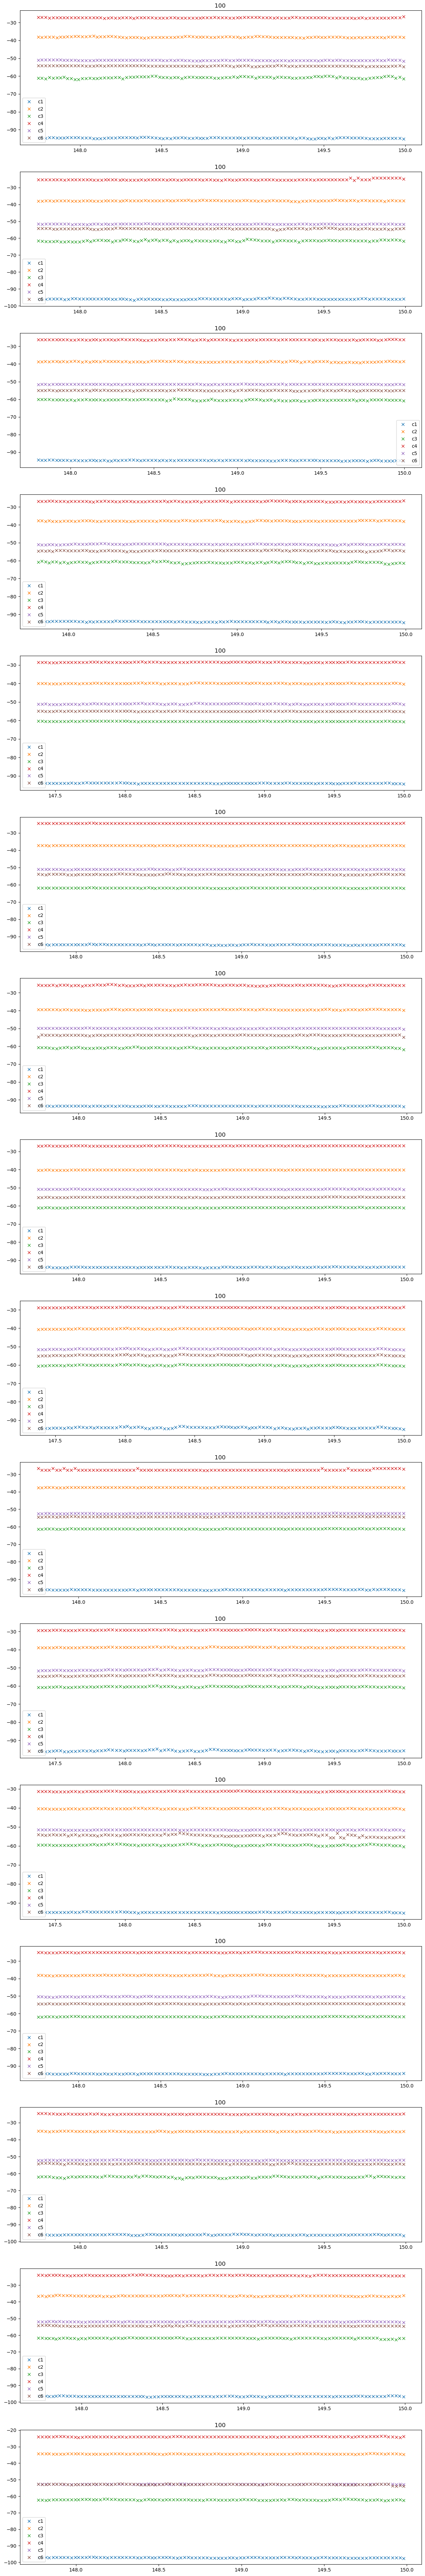

In [16]:
Dummy = plot_kurve(Processed_Data,zone=150,num_of_points=100,Columns=Col)

# KNN

In [19]:
X,y = X_and_y(Processed_Data,mode=1,zone=150,num_of_points=100)
many_times_test(X,y,times=10,rate=0.1,k=40,sigma= 1)

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations